In [19]:
import sys
import os

path = os.path.dirname(os.path.abspath("__file__"))
sys.path.insert(0, path + '/../')

from util.io import log_files
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.dpi":125, 'savefig.dpi':300})
# sns.set_context('paper')

import numpy as np
import pandas as pd

from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('retina')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


_ = importlib.reload(log_files)

In [20]:
sns.set(rc={"figure.dpi":125, 'savefig.dpi':300})
# uncomment the following lines for plots of better quality

# sns.set_context('paper')
# set_matplotlib_formats('retina')

## Logs 

Indicate in the variable ```logs``` the log directory containing tensorboard log files for each individual environment, generated via the command
```python
python train.py --flagfile inputs/[ENVIRONMENT_NAME]
```
If you did not change the option ```--logdir```, then your log files should be located in the directory
```
log/[ENVIRONMENT_NAME]
```
Each directory can contain logs for multiple instances, with different seeds (obtained via the option ```--seed```).

In [21]:
logs = {
    'CartPole': '../log/CartPole-v0',
    'MountainCar': '../log/MountainCar-v0',
    'Acrobot': '../log/Acrobot-v1',
    'Pendulum': '../log/PendulumRandomInit-v1',
    'LunarLander': '../log/LunarLanderContinuous-v2',
}

for key, value in logs.items():
    logs[key] = os.path.join(value, '**', '*.v2')

Load the WAE-MDP log dataframe

In [ ]:
df = pd.concat([
    log_files.get_event_dataframe(
        log_dir,
        tags=['eval_reconstruction_loss',
              'eval_wasserstein_regularizer',
              'reconstruction_loss',
              'local_reward_loss',
              'local_transition_loss',
              'local_transition_loss_empirical_transition_function',
              'steady_state_regularizer',
              'transition_loss',
              'reward_mse',
              'policy_evaluation_avg_rewards',
              'value_diff_empirical_latent_transition_function',
              'value_diff_latent_transition_function'],
        run_name='WAE-MDP',
        event_name=env,
        by_file=True,
    ) for env, log_dir in logs.items()],
    ignore_index=True)

df_by_file = df.copy()
df.pop('file')
df

In [23]:
_df = df[df['event'] != 'Pendulum']
_df_pendulum = df[df['step'] <= 4e5]
_df_pendulum = _df_pendulum[_df_pendulum['event'] == 'Pendulum']
df = pd.concat([_df, _df_pendulum], ignore_index=True)

Indicate to ```vae_mdp_dir``` the log directory containing VAE-MDP tensorboard log files for each individual environment.
The instructions for training VAE-MDPs models and retrieving those logs can be found in the [VAE-MDP implementation repository](https://github.com/florentdelgrange/vae_mdp).

In [24]:
# in our case, the related logs are located in the VAE-MDP directory
vae_mdp_dir = '../../vae_mdp/log'

vae_mdp_logs = {
    'CartPole': os.path.join(vae_mdp_dir, 'CartPole-v0'),
    'MountainCar': os.path.join(vae_mdp_dir, 'MountainCar-v0'),
    'Acrobot': os.path.join(vae_mdp_dir, 'Acrobot-v1'),
    'Pendulum': os.path.join(vae_mdp_dir, 'PendulumRandomInit-v0'),
    'LunarLander': os.path.join(vae_mdp_dir, 'LunarLanderContinuous-v2'),
}

for key, value in vae_mdp_logs.items():
    vae_mdp_logs[key] = os.path.join(value, '**', '*.v2')

Load the VAE-MDP log dataframe

In [ ]:
vae_df = pd.concat([
    log_files.get_event_dataframe(
        log_dir,
        tags=[
            'policy_evaluation_avg_rewards',
            'local_probability_loss',
            'local_reward_loss',
            'reward_mse',
            'local_transition_loss',
            'local_transition_loss_empirical_transition_function'],
        run_name='VAE-MDP',
        event_name=env,
    ) for env, log_dir in vae_mdp_logs.items()],
    ignore_index=True)

vae_df = vae_df[vae_df['step'] <= int(1e6)]

vae_df

In [26]:
_df = vae_df[vae_df['event'] != 'Pendulum']
_df_pendulum = vae_df[vae_df['step'] <= 4e5]
_df_pendulum = _df_pendulum[_df_pendulum['event'] == 'Pendulum']
vae_df = pd.concat([_df, _df_pendulum], ignore_index=True)

Load histogram data from your log files.

You mst provide a seed (to the variable ```seed```) to extract a single instance per Environment (should be a seed shared by all the environments).

In [27]:
hist = None
seed = 5

hist_logs = {key: value.replace('**', os.path.join('*seed={}*'.format(seed), '**')) for key, value in logs.items()}

for env, log_dir in hist_logs.items():
    _hist = log_files.get_event_dataframe(
        log_dir,
        tags=['state_frequency'],
        run_name='WAE-MDP',
        event_name=env,
        value_dtype=None)
    hist = _hist if hist is None else hist.append(_hist)

In [28]:
_df = hist[hist['event'] != 'Pendulum']
_df_pendulum = hist[hist['step'] <= 4e5]
_df_pendulum = _df_pendulum[_df_pendulum['event'] == 'Pendulum']
hist = pd.concat([_df, _df_pendulum], ignore_index=True)

Display the latent space distribution learned for each environment (for the instance with input seed)

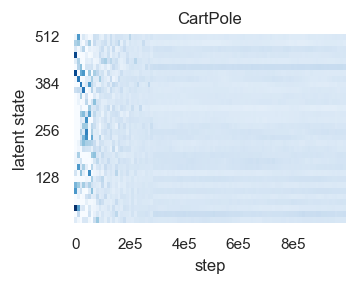

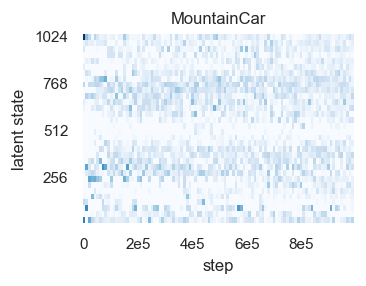

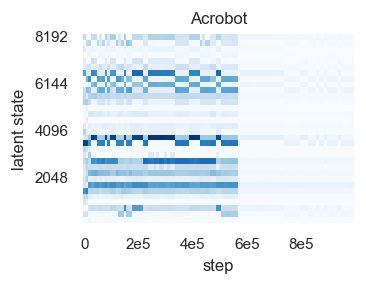

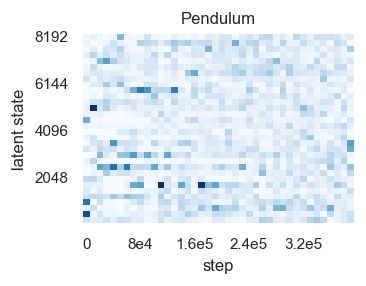

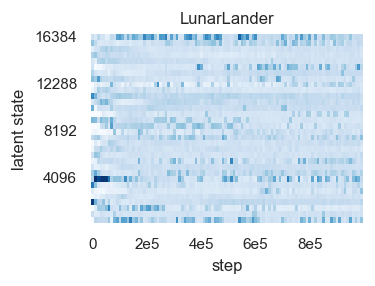

In [29]:
importlib.reload(log_files)

# uncomment for plots of better quality
# plt.rcParams['figure.dpi'] = 300
sns.set_context('paper')

for environment in logs.keys():
    g = log_files.plot_histograms_per_step(
        hist[hist['event'] == environment],
        num_x_ticks=5, num_y_ticks=4,
        aspect=2,)
    plt.savefig(environment + '_histogram.pdf', bbox_inches='tight')

In [30]:
_df = hist[hist['event'] != 'Pendulum']
_df_pendulum = hist[hist['step'] <= 4e5]
_df_pendulum = _df_pendulum[_df_pendulum['event'] == 'Pendulum']
hist = pd.concat([_df, _df_pendulum], ignore_index=True)

# Plots

The code for plotting the Figures presented in the paper is provided in the following.
We additionally provide de code for plotting the Figures without VAE-MDP comparisons (below).

Reconstruction loss and Wasserstein Regularizers

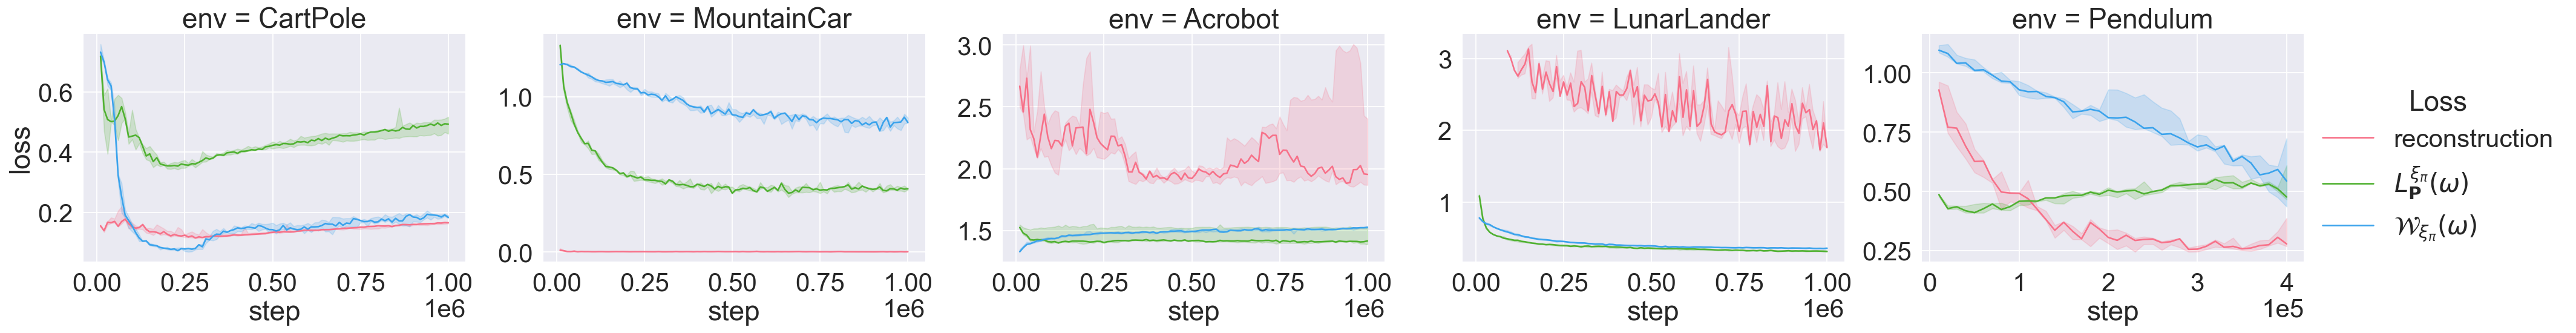

In [31]:
sns.set_context('paper')
sns.set(font_scale=1.25)
_df = pd.concat(
        df[df['tag'] == tag] for tag in [
            'reconstruction_loss',
            'transition_loss',
            'steady_state_regularizer',])
_df = _df[_df['step'] % 1e4 == 0]
# ignore outliers
_df = _df[_df['value'] < 3.2]

sns.set_context('paper')
sns.set(font_scale=2.2)
g = sns.relplot(
    data=_df.rename(
        columns={
            "value": 'loss',
            "run": "embedding",
            "event": "env",
            "tag": 'Loss'}
    ).replace({
        'reconstruction_loss': 'reconstruction',
        'transition_loss': '$L_{\mathbf{P}}^{\\xi_{{\pi}}}(\omega)$',
        'steady_state_regularizer': '$\mathcal{W}_{\\xi_{{\pi}}}(\omega)$'}),
    x='step',
    y='loss',
    col='env',
    facet_kws=dict(sharex=False, sharey=False),
    ci=85,
    hue='Loss',
    estimator=np.median,
    kind='line',
    aspect=1.25,
    palette='husl')

plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.savefig("loss.pdf")
plt.show()

Local Losses

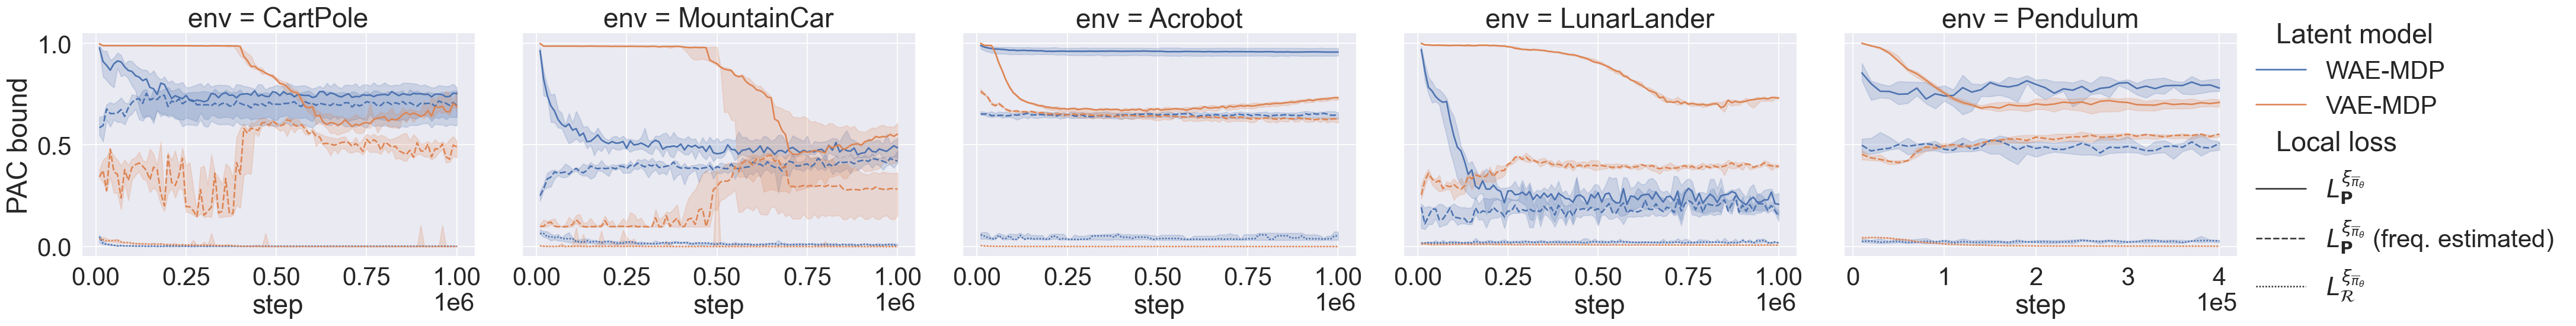

In [32]:
_df = pd.concat(
        df[df['tag'] == tag] for tag in [
            # 'transition_loss',
            'local_transition_loss',
            'local_transition_loss_empirical_transition_function',
            'local_reward_loss'])
_df = _df[_df['step'] % 1e3 == 0]
_df['model'] = 'WAE-MDP'
_vae_df = pd.concat(
    vae_df[vae_df['tag'] == tag] for tag in [
        'local_probability_loss',
        'local_transition_loss',
        'local_reward_loss',
        'local_transition_loss_empirical_transition_function'])
_vae_df[_vae_df['value'] > 1.] = 1.
_vae_df['model'] = 'VAE-MDP'
_vae_df_copy = _vae_df.copy()
_df = pd.concat([_df, _vae_df, _vae_df_copy], ignore_index=True)

sns.set_context('paper')
sns.set(font_scale=2.2)
g = sns.relplot(
    data=_df[_df['step'] % int(1e3) == 0].rename(
        columns={
            "value": 'PAC bound',
            "event": "env",
            "model": 'Latent model',
            "tag": "Local loss"}
    ).replace({
        'transition_loss': 'transition (training)',
        'local_transition_loss': "$L_{\mathbf{P}}^{\\xi_{\overline{\pi}_{\\theta}}}$",
        'local_transition_loss_empirical_transition_function': '$L_{\mathbf{P}}^{\\xi_{\overline{\pi}_{\\theta}}}$ (freq. estimated)',
        'local_probability_loss': 'transition \n(freq. estimated)',
        'local_reward_loss': '$L_{\mathcal{R}}^{\\xi_{\overline{\pi}_{\\theta}}}$',
        'reconstruction_loss': 'reconstruction',
        'transition_loss': 'transition regularizer',
        'steady_state_regularizer': 'steady-state regularizer'
    }),
    x='step',
    y='PAC bound',
    col='env',
    style='Local loss',
    hue='Latent model',
    facet_kws=dict(sharex=False, sharey=True),
    ci=95,
    estimator=np.median,
    kind='line',
    aspect=1.25,)

plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.savefig("local_losses.pdf")
plt.show()

Policy Evaluation

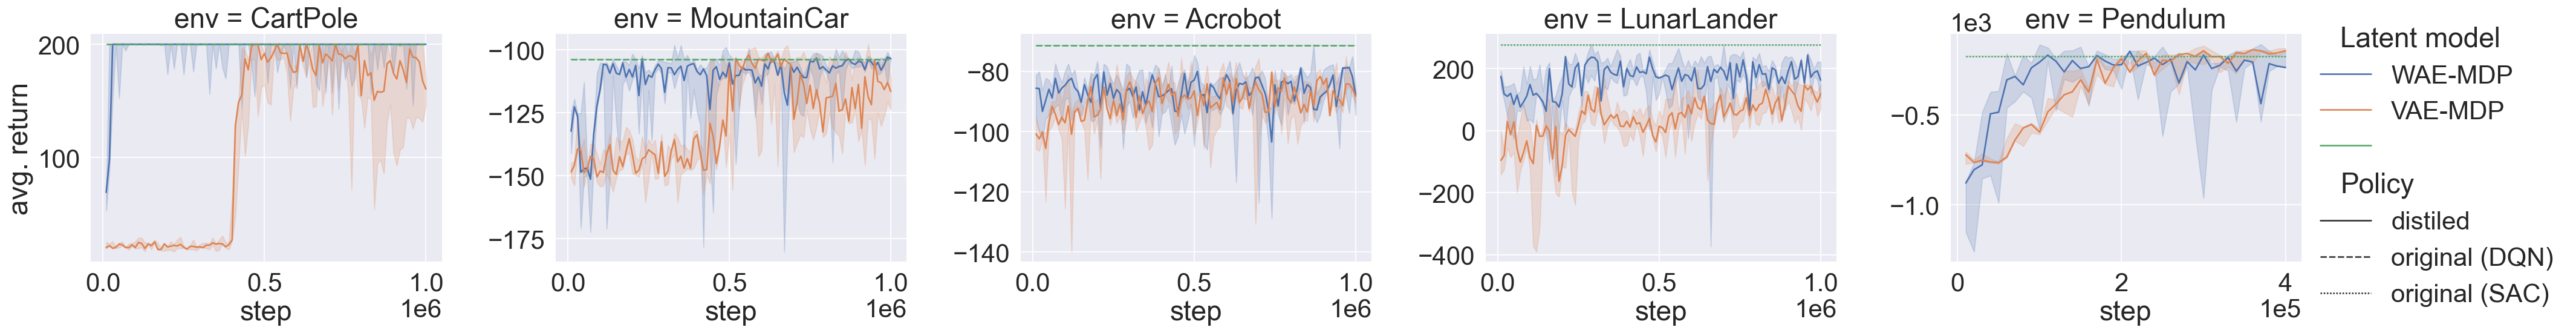

In [33]:
original_policy = {
    'CartPole': ['DQN', 200],
    'MountainCar': ['DQN', -103.8],
    'Acrobot': ['DQN', -71.3],
    'LunarLander': ['SAC', 277.299713],
    'Pendulum': ['SAC', -175.941193], 
}

_df = pd.concat(
        df[df['tag'] == tag] for tag in [
            'policy_evaluation_avg_rewards'])
_vae_df = vae_df[vae_df['tag'] == 'policy_evaluation_avg_rewards']
_df = pd.concat([_df, _vae_df], ignore_index=True)
_df['Policy'] = 'distiled'
_original_df = pd.concat([
    _df[_df['event'] == key].assign(Policy='original ({})'.format(value[0]), run='', value=value[1])
    for key, value in original_policy.items()
], ignore_index=True)
_df = pd.concat([_df, _original_df], ignore_index=True)
# _df = _df.append(_df.assign(run='original', value=300))

sns.set_context('paper')
sns.set(font_scale=2.2)
g = sns.relplot(
    data=_df[_df['step'] % int(1e3) == 0].rename(
        columns={
            "run": "Latent model",
            "event": "env",
            "value": "avg. return"}),
    x='step',
    y='avg. return',
    col='env',
    hue='Latent model',
    style='Policy',
    facet_kws=dict(sharex=False, sharey=False),
    ci=88,
    estimator=np.median,
    kind='line',
    aspect=1.25,)

plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.savefig("eval_policy.pdf")
plt.show()

### Plots without VAE-MDPs

Local Losses

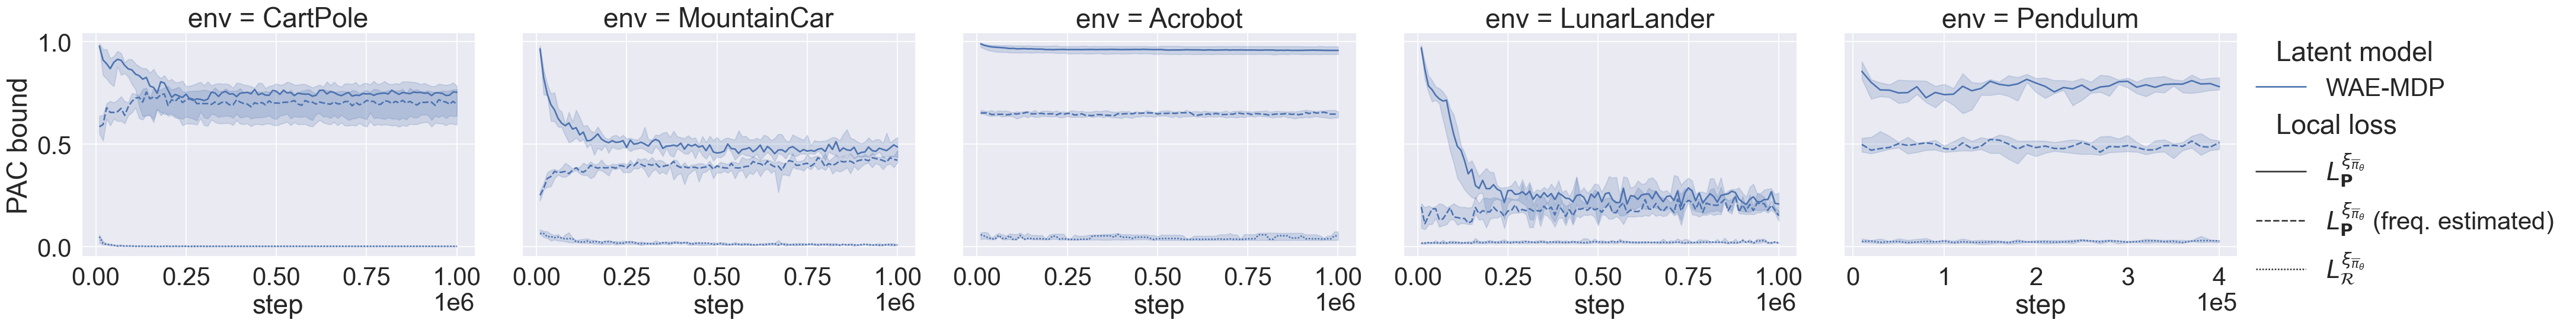

In [34]:
_df = pd.concat(
        df[df['tag'] == tag] for tag in [
            # 'transition_loss',
            'local_transition_loss',
            'local_transition_loss_empirical_transition_function',
            'local_reward_loss'])
_df = _df[_df['step'] % 1e3 == 0]
_df['model'] = 'WAE-MDP'

sns.set_context('paper')
sns.set(font_scale=2.2)
g = sns.relplot(
    data=_df[_df['step'] % int(1e3) == 0].rename(
        columns={
            "value": 'PAC bound',
            "event": "env",
            "model": 'Latent model',
            "tag": "Local loss"}
    ).replace({
        'transition_loss': 'transition (training)',
        'local_transition_loss': "$L_{\mathbf{P}}^{\\xi_{\overline{\pi}_{\\theta}}}$",
        'local_transition_loss_empirical_transition_function': '$L_{\mathbf{P}}^{\\xi_{\overline{\pi}_{\\theta}}}$ (freq. estimated)',
        'local_probability_loss': 'transition \n(freq. estimated)',
        'local_reward_loss': '$L_{\mathcal{R}}^{\\xi_{\overline{\pi}_{\\theta}}}$',
        'reconstruction_loss': 'reconstruction',
        'transition_loss': 'transition regularizer',
        'steady_state_regularizer': 'steady-state regularizer'
    }),
    x='step',
    y='PAC bound',
    col='env',
    style='Local loss',
    hue='Latent model',
    facet_kws=dict(sharex=False, sharey=True),
    ci=95,
    estimator=np.median,
    kind='line',
    aspect=1.25,)

plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.savefig("local_losses_wae_only.pdf")
plt.show()

Policy Evaluation

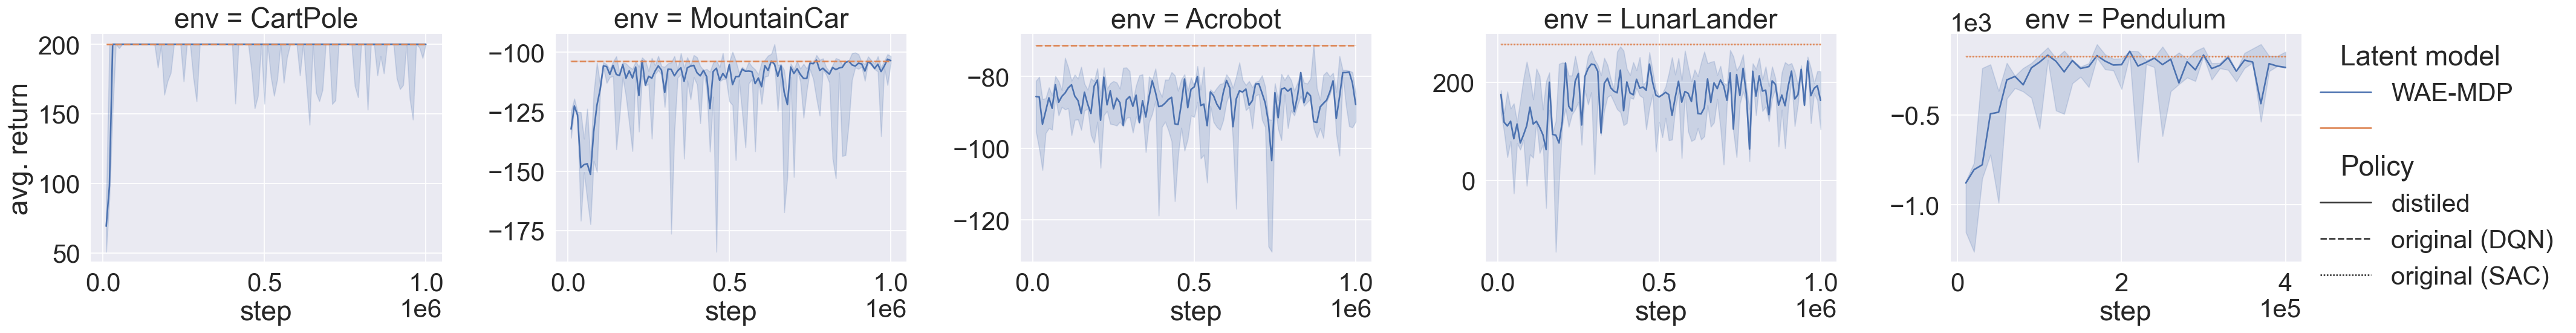

In [35]:
original_policy = {
    'CartPole': ['DQN', 200],
    'MountainCar': ['DQN', -103.8],
    'Acrobot': ['DQN', -71.3],
    'LunarLander': ['SAC', 277.299713],
    'Pendulum': ['SAC', -175.941193], 
}

_df = pd.concat(
        df[df['tag'] == tag] for tag in [
            'policy_evaluation_avg_rewards'])
_df['Policy'] = 'distiled'
_original_df = pd.concat([
    _df[_df['event'] == key].assign(Policy='original ({})'.format(value[0]), run='', value=value[1])
    for key, value in original_policy.items()
], ignore_index=True)
_df = pd.concat([_df, _original_df], ignore_index=True)
# _df = _df.append(_df.assign(run='original', value=300))

sns.set_context('paper')
sns.set(font_scale=2.2)
g = sns.relplot(
    data=_df[_df['step'] % int(1e3) == 0].rename(
        columns={
            "run": "Latent model",
            "event": "env",
            "value": "avg. return"}),
    x='step',
    y='avg. return',
    col='env',
    hue='Latent model',
    style='Policy',
    facet_kws=dict(sharex=False, sharey=False),
    ci=88,
    estimator=np.median,
    kind='line',
    aspect=1.25,)

plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.savefig("eval_policy_wae_only.pdf")
plt.show()

### Summary

/var/folders/jr/mbdcmtbs4pg2gc3l8smjgd100000gn/T/ipykernel_14926/796083979.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss['metric'] = 'loss'


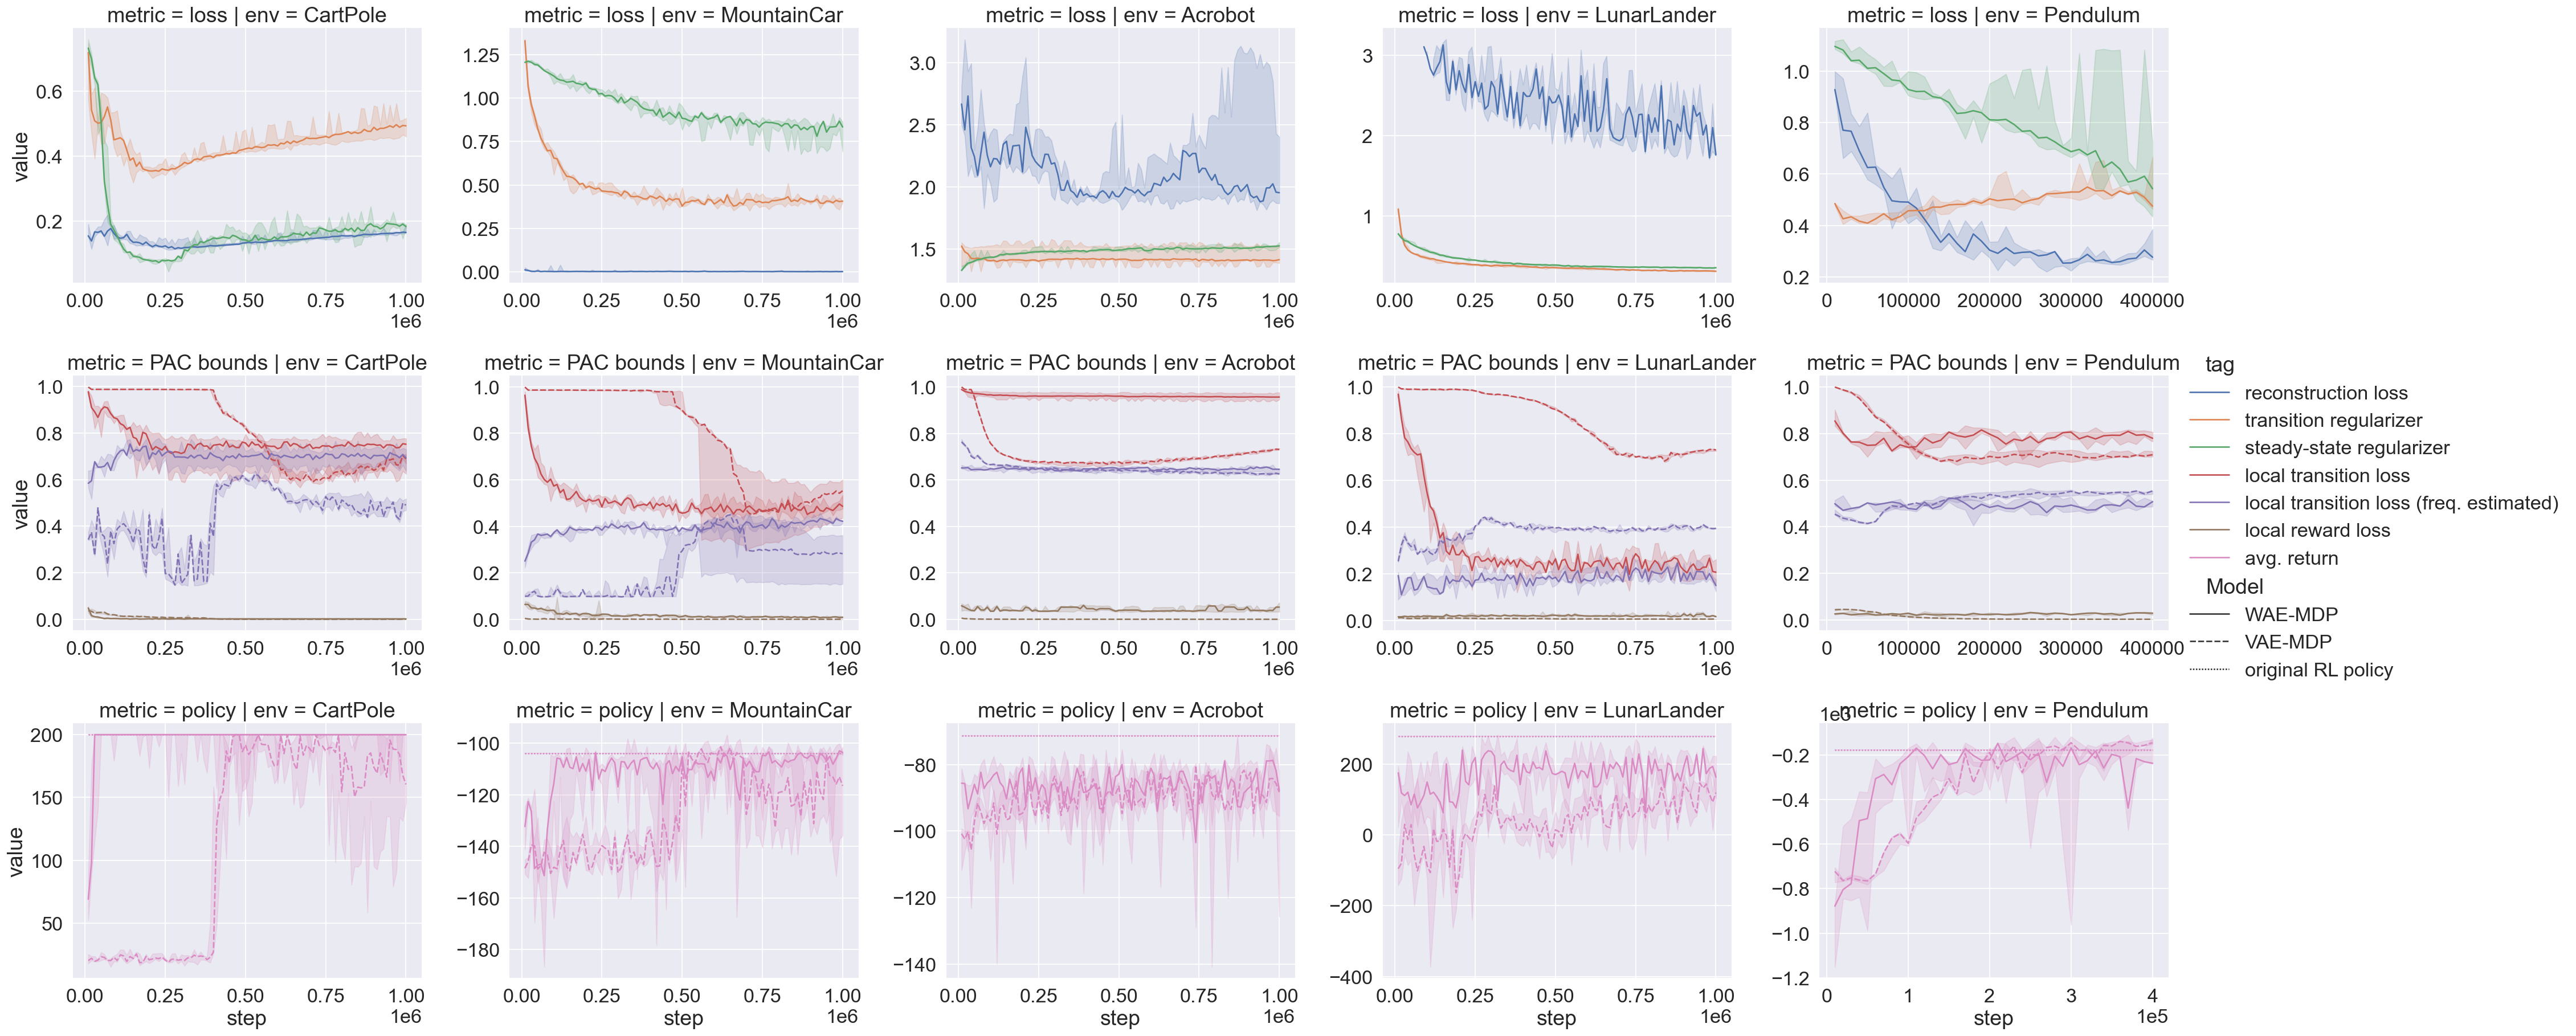

In [36]:
_df = pd.concat(
        df[df['tag'] == tag] for tag in [
            'reconstruction_loss',
            'transition_loss',
            'steady_state_regularizer',])
_df = _df[_df['step'] % 1e4 == 0]
# ignore outliers
df_loss = _df[_df['value'] < 3.2]
df_loss['metric'] = 'loss'

_df = pd.concat(
        df[df['tag'] == tag] for tag in [
            # 'transition_loss',
            'local_transition_loss',
            'local_transition_loss_empirical_transition_function',
            'local_reward_loss'])
_df = _df[_df['step'] % 1e3 == 0]
_vae_df = pd.concat(
    vae_df[vae_df['tag'] == tag] for tag in [
        'local_probability_loss',
        'local_transition_loss',
        'local_reward_loss',
        'local_transition_loss_empirical_transition_function'])
_vae_df[_vae_df['value'] > 1.] = 1.
_vae_df_copy = _vae_df.copy()
df_pac_bounds = pd.concat([_df, _vae_df, _vae_df_copy], ignore_index=True)
df_pac_bounds['metric'] = 'PAC bounds'

original_policy = {
    'CartPole': ['DQN', 200],
    'MountainCar': ['DQN', -103.8],
    'Acrobot': ['DQN', -71.3],
    'LunarLander': ['SAC', 277.299713],
    'Pendulum': ['SAC', -175.941193], 
}

_df = pd.concat(
        df[df['tag'] == tag] for tag in [
            'policy_evaluation_avg_rewards'])
_vae_df = vae_df[vae_df['tag'] == 'policy_evaluation_avg_rewards']
_df = pd.concat([_df, _vae_df], ignore_index=True)
# _df['Policy'] = 'distiled'
_original_df = pd.concat([
    _df[_df['event'] == key].assign(run='original RL policy', value=value[1])
    for key, value in original_policy.items()
], ignore_index=True)
df_eval_policy = pd.concat([_original_df, _df], ignore_index=True)
df_eval_policy['metric'] = 'policy'

_df = pd.concat([df_loss, df_pac_bounds, df_eval_policy], ignore_index=True)

sns.set_context('paper')
sns.set(font_scale=1.8)
g = sns.relplot(
    data=_df[_df['step'] % int(1e3) == 0].rename(
        columns={
            "run": "Model",
            "event": "env",}
    ).replace({
        'local_transition_loss': 'local transition loss',
        'local_transition_loss_empirical_transition_function': 'local transition loss (freq. estimated)',
        'local_probability_loss': 'local transition loss (freq. estimated)',
        'local_reward_loss': 'local reward loss',
        'reconstruction_loss': 'reconstruction loss',
        'transition_loss': 'transition regularizer',
        'steady_state_regularizer': 'steady-state regularizer',
        'policy_evaluation_avg_rewards': 'avg. return'
    }),
    x='step',
    y='value',
    col='env',
    row='metric',
    style='Model',
    hue='tag',
    facet_kws=dict(sharex=False, sharey=False),
    ci=88,
    estimator=np.median,
    kind='line',
    aspect=1.25,)

plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.savefig("experiments.pdf")
plt.show()